In [41]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from fuzzy_layer import FuzzyLayer

In [42]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 2
fuzzy_labels = 12 #10 цифр + 2 класса на цифры с кругляшками и без
unknown_classes_ratio = 0.5 # доля неизвестных классов 
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [44]:
def get_target_and_mask(target_label, unknown_ratio):
    x = torch.LongTensor([target_label])
    t = F.one_hot(torch.LongTensor([x]), fuzzy_labels)
    if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
        t[0][fuzzy_labels - 2] = 1
    else:
        t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    return torch.cat((t, m), 0).to(device) # target + mask

In [45]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [46]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [47]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [48]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [49]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [50]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        input_dim (int): Размерность входных данных.
        hidden_dim (int): Размер внутренних слоев.
        latent_dim (int): Размер латентного вектора.
    """
    def __init__(self, latent_dim, labels_count):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)

        self.fuzzy = nn.Sequential(
             FuzzyLayer.fromdimentions(latent_dim, labels_count, trainable=True)

        )
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        labels = self.fuzzy(mu)

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu)

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [51]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean() #torch.mean(torch.mul(weight, torch.sum(torch.square(predicted_labels-oh), dim=-1)))

    loss = loss_recon + loss_kl

    if is_fuzzy_loss_active:
        loss += loss_fuzzy

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [52]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,690,329


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=4, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=2, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [53]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [54]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [55]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [56]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 22.0288 (Recon: 20.3486, KL: 0.1602 Fuzzy: 1.5200) Grad: 14.3652
Step 100 (N samples: 25,600), Loss: 8.1555 (Recon: 6.9668, KL: 0.3894 Fuzzy: 0.7994) Grad: 7.6693
Step 200 (N samples: 51,200), Loss: 7.9399 (Recon: 6.8047, KL: 0.4743 Fuzzy: 0.6609) Grad: 3.6898


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.7497 (BCE: 6.7184, KLD: 0.6635 Fuzzy: 1.3678 Accuracy 0.2424)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.7350 (Recon: 6.5612, KL: 0.5961 Fuzzy: 0.5777) Grad: 4.6414
Step 400 (N samples: 102,400), Loss: 7.9573 (Recon: 6.7505, KL: 0.5633 Fuzzy: 0.6435) Grad: 3.8047


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.4554 (BCE: 6.5748, KLD: 0.7328 Fuzzy: 1.1478 Accuracy 0.4398)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.5989 (Recon: 6.4092, KL: 0.6824 Fuzzy: 0.5073) Grad: 4.9176
Step 600 (N samples: 153,600), Loss: 7.6071 (Recon: 6.4564, KL: 0.6858 Fuzzy: 0.4649) Grad: 2.8856
Step 700 (N samples: 179,200), Loss: 7.7676 (Recon: 6.5498, KL: 0.7139 Fuzzy: 0.5039) Grad: 2.6185


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.1211 (BCE: 6.3947, KLD: 0.7529 Fuzzy: 0.9735 Accuracy 0.5362)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.6076 (Recon: 6.4438, KL: 0.6863 Fuzzy: 0.4775) Grad: 3.8660
Step 900 (N samples: 230,400), Loss: 7.4397 (Recon: 6.3337, KL: 0.7389 Fuzzy: 0.3671) Grad: 2.4424


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9750 (BCE: 6.3171, KLD: 0.7311 Fuzzy: 0.9269 Accuracy 0.5840)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.4286 (Recon: 6.2092, KL: 0.7381 Fuzzy: 0.4814) Grad: 3.0977
Step 1,100 (N samples: 281,600), Loss: 7.6237 (Recon: 6.2958, KL: 0.7938 Fuzzy: 0.5341) Grad: 2.2730


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9159 (BCE: 6.2500, KLD: 0.7940 Fuzzy: 0.8719 Accuracy 0.6122)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.6152 (Recon: 6.3355, KL: 0.7840 Fuzzy: 0.4956) Grad: 3.1059
Step 1,300 (N samples: 332,800), Loss: 7.3873 (Recon: 6.1542, KL: 0.8306 Fuzzy: 0.4024) Grad: 2.1902
Step 1,400 (N samples: 358,400), Loss: 7.6341 (Recon: 6.3883, KL: 0.7949 Fuzzy: 0.4508) Grad: 3.1115


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.8663 (BCE: 6.2600, KLD: 0.7735 Fuzzy: 0.8328 Accuracy 0.6483)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.4350 (Recon: 6.1616, KL: 0.8731 Fuzzy: 0.4004) Grad: 1.7420
Step 1,600 (N samples: 409,600), Loss: 7.3941 (Recon: 6.1382, KL: 0.8404 Fuzzy: 0.4155) Grad: 1.5229


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9624 (BCE: 6.0691, KLD: 1.0399 Fuzzy: 0.8534 Accuracy 0.6380)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.4465 (Recon: 6.1796, KL: 0.8953 Fuzzy: 0.3716) Grad: 2.6344
Step 1,800 (N samples: 460,800), Loss: 7.4581 (Recon: 6.1778, KL: 0.8814 Fuzzy: 0.3989) Grad: 1.6364


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7812 (BCE: 6.1649, KLD: 0.8803 Fuzzy: 0.7361 Accuracy 0.6872)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.2387 (Recon: 6.0193, KL: 0.8923 Fuzzy: 0.3271) Grad: 3.0935
Step 2,000 (N samples: 512,000), Loss: 7.5822 (Recon: 6.3080, KL: 0.8874 Fuzzy: 0.3868) Grad: 1.8131
Step 2,100 (N samples: 537,600), Loss: 7.5520 (Recon: 6.2315, KL: 0.9334 Fuzzy: 0.3871) Grad: 1.7263


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7355 (BCE: 6.0923, KLD: 0.9248 Fuzzy: 0.7184 Accuracy 0.7139)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.3662 (Recon: 6.0442, KL: 0.9301 Fuzzy: 0.3919) Grad: 2.4506
Step 2,300 (N samples: 588,800), Loss: 7.4851 (Recon: 6.2504, KL: 0.9020 Fuzzy: 0.3327) Grad: 2.2253


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7277 (BCE: 6.0518, KLD: 0.9789 Fuzzy: 0.6970 Accuracy 0.7616)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.2737 (Recon: 5.9793, KL: 0.9493 Fuzzy: 0.3450) Grad: 2.5953
Step 2,500 (N samples: 640,000), Loss: 7.3550 (Recon: 6.0492, KL: 0.9260 Fuzzy: 0.3798) Grad: 2.2297


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6562 (BCE: 6.0730, KLD: 0.9158 Fuzzy: 0.6675 Accuracy 0.7854)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.4040 (Recon: 6.0817, KL: 0.9417 Fuzzy: 0.3806) Grad: 1.8522
Step 2,700 (N samples: 691,200), Loss: 7.3631 (Recon: 6.0937, KL: 0.9277 Fuzzy: 0.3417) Grad: 2.6061
Step 2,800 (N samples: 716,800), Loss: 7.3080 (Recon: 6.0595, KL: 0.8950 Fuzzy: 0.3535) Grad: 1.6890


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.6510 (BCE: 5.9958, KLD: 1.0221 Fuzzy: 0.6331 Accuracy 0.8040)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,900 (N samples: 742,400), Loss: 7.2656 (Recon: 6.0142, KL: 0.9560 Fuzzy: 0.2954) Grad: 2.6223
Step 3,000 (N samples: 768,000), Loss: 7.1595 (Recon: 5.8916, KL: 0.9599 Fuzzy: 0.3080) Grad: 3.0092


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5988 (BCE: 5.9862, KLD: 1.0050 Fuzzy: 0.6075 Accuracy 0.8210)
Epoch 14/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,100 (N samples: 793,600), Loss: 7.1975 (Recon: 5.9239, KL: 0.9625 Fuzzy: 0.3110) Grad: 1.3719
Step 3,200 (N samples: 819,200), Loss: 7.2117 (Recon: 5.9648, KL: 0.9589 Fuzzy: 0.2881) Grad: 1.3054


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5541 (BCE: 5.9968, KLD: 0.9727 Fuzzy: 0.5847 Accuracy 0.8319)
Epoch 15/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,300 (N samples: 844,800), Loss: 7.3711 (Recon: 6.0227, KL: 1.0208 Fuzzy: 0.3277) Grad: 1.6933
Step 3,400 (N samples: 870,400), Loss: 7.4073 (Recon: 6.1764, KL: 0.9645 Fuzzy: 0.2665) Grad: 1.9805
Step 3,500 (N samples: 896,000), Loss: 7.2386 (Recon: 5.9409, KL: 0.9907 Fuzzy: 0.3070) Grad: 2.5768


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5763 (BCE: 6.0171, KLD: 0.9725 Fuzzy: 0.5867 Accuracy 0.8263)
Epoch 16/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,600 (N samples: 921,600), Loss: 7.3412 (Recon: 6.0198, KL: 1.0014 Fuzzy: 0.3200) Grad: 1.8907
Step 3,700 (N samples: 947,200), Loss: 7.1900 (Recon: 5.9312, KL: 0.9971 Fuzzy: 0.2617) Grad: 1.6944


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5421 (BCE: 6.0187, KLD: 0.9486 Fuzzy: 0.5748 Accuracy 0.8463)
Epoch 17/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 3,800 (N samples: 972,800), Loss: 7.3664 (Recon: 6.0616, KL: 0.9732 Fuzzy: 0.3315) Grad: 1.6322
Step 3,900 (N samples: 998,400), Loss: 7.3062 (Recon: 6.0109, KL: 0.9798 Fuzzy: 0.3156) Grad: 1.3274


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5717 (BCE: 6.0152, KLD: 0.9885 Fuzzy: 0.5680 Accuracy 0.8558)
Epoch 18/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,000 (N samples: 1,024,000), Loss: 7.4536 (Recon: 6.1522, KL: 0.9797 Fuzzy: 0.3217) Grad: 2.1869
Step 4,100 (N samples: 1,049,600), Loss: 7.3121 (Recon: 6.0242, KL: 1.0263 Fuzzy: 0.2615) Grad: 1.3835
Step 4,200 (N samples: 1,075,200), Loss: 7.3374 (Recon: 5.9743, KL: 1.0263 Fuzzy: 0.3368) Grad: 1.4682


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5698 (BCE: 5.9998, KLD: 1.0045 Fuzzy: 0.5656 Accuracy 0.8633)
Epoch 19/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,300 (N samples: 1,100,800), Loss: 7.4159 (Recon: 6.0868, KL: 1.0127 Fuzzy: 0.3163) Grad: 1.4732
Step 4,400 (N samples: 1,126,400), Loss: 7.1396 (Recon: 5.8707, KL: 0.9972 Fuzzy: 0.2717) Grad: 1.2997


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4942 (BCE: 5.9132, KLD: 1.0353 Fuzzy: 0.5457 Accuracy 0.8828)
Epoch 20/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,500 (N samples: 1,152,000), Loss: 7.3276 (Recon: 6.0158, KL: 1.0356 Fuzzy: 0.2762) Grad: 1.3674
Step 4,600 (N samples: 1,177,600), Loss: 7.6570 (Recon: 6.3194, KL: 1.0464 Fuzzy: 0.2912) Grad: 3.9012


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5094 (BCE: 5.9564, KLD: 1.0042 Fuzzy: 0.5487 Accuracy 0.8938)
Epoch 21/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 4,700 (N samples: 1,203,200), Loss: 7.0933 (Recon: 5.8174, KL: 1.0337 Fuzzy: 0.2422) Grad: 1.3407
Step 4,800 (N samples: 1,228,800), Loss: 7.2888 (Recon: 5.9985, KL: 1.0382 Fuzzy: 0.2521) Grad: 2.1816
Step 4,900 (N samples: 1,254,400), Loss: 7.1744 (Recon: 5.8996, KL: 1.0109 Fuzzy: 0.2639) Grad: 0.9288


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4844 (BCE: 5.9724, KLD: 0.9984 Fuzzy: 0.5137 Accuracy 0.9093)
Epoch 22/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,000 (N samples: 1,280,000), Loss: 7.2585 (Recon: 5.9431, KL: 0.9989 Fuzzy: 0.3165) Grad: 1.5197
Step 5,100 (N samples: 1,305,600), Loss: 7.4014 (Recon: 6.1205, KL: 0.9915 Fuzzy: 0.2894) Grad: 2.1461


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4781 (BCE: 5.9345, KLD: 1.0267 Fuzzy: 0.5169 Accuracy 0.9138)
Epoch 23/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,200 (N samples: 1,331,200), Loss: 7.1991 (Recon: 5.8952, KL: 1.0505 Fuzzy: 0.2534) Grad: 1.1215
Step 5,300 (N samples: 1,356,800), Loss: 7.1400 (Recon: 5.7955, KL: 1.0665 Fuzzy: 0.2780) Grad: 1.0540
Step 5,400 (N samples: 1,382,400), Loss: 7.1999 (Recon: 5.9141, KL: 1.0184 Fuzzy: 0.2675) Grad: 1.4993


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4680 (BCE: 5.9369, KLD: 1.0288 Fuzzy: 0.5023 Accuracy 0.9192)
Epoch 24/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,500 (N samples: 1,408,000), Loss: 7.2264 (Recon: 5.9314, KL: 1.0140 Fuzzy: 0.2810) Grad: 1.5411
Step 5,600 (N samples: 1,433,600), Loss: 7.2595 (Recon: 5.9251, KL: 1.0604 Fuzzy: 0.2739) Grad: 1.8080


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4690 (BCE: 5.9194, KLD: 1.0446 Fuzzy: 0.5050 Accuracy 0.9195)
Epoch 25/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,700 (N samples: 1,459,200), Loss: 7.3806 (Recon: 6.0992, KL: 1.0202 Fuzzy: 0.2612) Grad: 1.7066
Step 5,800 (N samples: 1,484,800), Loss: 7.2485 (Recon: 5.9495, KL: 1.0580 Fuzzy: 0.2409) Grad: 1.2830


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4715 (BCE: 5.9128, KLD: 1.0539 Fuzzy: 0.5048 Accuracy 0.9229)
Epoch 26/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 5,900 (N samples: 1,510,400), Loss: 7.4422 (Recon: 6.1513, KL: 1.0240 Fuzzy: 0.2669) Grad: 1.6017
Step 6,000 (N samples: 1,536,000), Loss: 7.2575 (Recon: 5.9075, KL: 1.0635 Fuzzy: 0.2865) Grad: 1.9548
Step 6,100 (N samples: 1,561,600), Loss: 7.0131 (Recon: 5.6936, KL: 1.0636 Fuzzy: 0.2559) Grad: 1.7069


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4642 (BCE: 5.9496, KLD: 1.0132 Fuzzy: 0.5015 Accuracy 0.9208)
Epoch 27/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,200 (N samples: 1,587,200), Loss: 7.3614 (Recon: 6.0583, KL: 1.0779 Fuzzy: 0.2251) Grad: 1.5081
Step 6,300 (N samples: 1,612,800), Loss: 7.2642 (Recon: 5.9630, KL: 1.0454 Fuzzy: 0.2558) Grad: 1.5520


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4612 (BCE: 5.9424, KLD: 1.0173 Fuzzy: 0.5015 Accuracy 0.9213)
Epoch 28/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,400 (N samples: 1,638,400), Loss: 7.3200 (Recon: 6.0344, KL: 1.0447 Fuzzy: 0.2409) Grad: 1.1786
Step 6,500 (N samples: 1,664,000), Loss: 7.0941 (Recon: 5.7770, KL: 1.0737 Fuzzy: 0.2433) Grad: 1.3653


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4420 (BCE: 5.9144, KLD: 1.0277 Fuzzy: 0.4999 Accuracy 0.9198)
Epoch 29/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,600 (N samples: 1,689,600), Loss: 7.2867 (Recon: 5.9616, KL: 1.0524 Fuzzy: 0.2727) Grad: 1.1895
Step 6,700 (N samples: 1,715,200), Loss: 7.0094 (Recon: 5.7122, KL: 1.0992 Fuzzy: 0.1980) Grad: 1.6380
Step 6,800 (N samples: 1,740,800), Loss: 7.3044 (Recon: 6.0080, KL: 1.0406 Fuzzy: 0.2558) Grad: 2.0548


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4291 (BCE: 5.8834, KLD: 1.0629 Fuzzy: 0.4828 Accuracy 0.9282)
Epoch 30/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 6,900 (N samples: 1,766,400), Loss: 7.4430 (Recon: 6.1530, KL: 1.0525 Fuzzy: 0.2375) Grad: 2.8693
Step 7,000 (N samples: 1,792,000), Loss: 7.2135 (Recon: 5.8587, KL: 1.0318 Fuzzy: 0.3230) Grad: 1.8041


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4400 (BCE: 5.9249, KLD: 1.0254 Fuzzy: 0.4897 Accuracy 0.9309)
Epoch 31/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,100 (N samples: 1,817,600), Loss: 7.2157 (Recon: 5.8848, KL: 1.0520 Fuzzy: 0.2790) Grad: 1.7227
Step 7,200 (N samples: 1,843,200), Loss: 7.3065 (Recon: 5.9968, KL: 1.0608 Fuzzy: 0.2489) Grad: 1.3965


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4479 (BCE: 5.8970, KLD: 1.0422 Fuzzy: 0.5087 Accuracy 0.9210)
Epoch 32/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,300 (N samples: 1,868,800), Loss: 7.0572 (Recon: 5.7198, KL: 1.0919 Fuzzy: 0.2455) Grad: 1.9824
Step 7,400 (N samples: 1,894,400), Loss: 7.1380 (Recon: 5.8701, KL: 1.0546 Fuzzy: 0.2133) Grad: 1.6656
Step 7,500 (N samples: 1,920,000), Loss: 7.3129 (Recon: 5.9519, KL: 1.1143 Fuzzy: 0.2467) Grad: 1.6482


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4499 (BCE: 5.8803, KLD: 1.0752 Fuzzy: 0.4944 Accuracy 0.9306)
Epoch 33/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,600 (N samples: 1,945,600), Loss: 7.2601 (Recon: 5.9405, KL: 1.0818 Fuzzy: 0.2379) Grad: 1.5186
Step 7,700 (N samples: 1,971,200), Loss: 7.0230 (Recon: 5.7501, KL: 1.0573 Fuzzy: 0.2155) Grad: 1.2655


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4481 (BCE: 5.9246, KLD: 1.0389 Fuzzy: 0.4846 Accuracy 0.9283)
Epoch 34/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 7,800 (N samples: 1,996,800), Loss: 7.3538 (Recon: 6.0486, KL: 1.0365 Fuzzy: 0.2686) Grad: 1.5444
Step 7,900 (N samples: 2,022,400), Loss: 7.2188 (Recon: 5.8292, KL: 1.0935 Fuzzy: 0.2961) Grad: 1.5620


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4246 (BCE: 5.8634, KLD: 1.0789 Fuzzy: 0.4824 Accuracy 0.9328)
Epoch 35/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,000 (N samples: 2,048,000), Loss: 7.0773 (Recon: 5.7516, KL: 1.0634 Fuzzy: 0.2623) Grad: 1.3672
Step 8,100 (N samples: 2,073,600), Loss: 7.1060 (Recon: 5.7434, KL: 1.0452 Fuzzy: 0.3174) Grad: 1.2424
Step 8,200 (N samples: 2,099,200), Loss: 7.3464 (Recon: 5.9827, KL: 1.0637 Fuzzy: 0.3001) Grad: 1.5763


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4498 (BCE: 5.8540, KLD: 1.0959 Fuzzy: 0.4999 Accuracy 0.9307)
Epoch 36/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,300 (N samples: 2,124,800), Loss: 7.2390 (Recon: 5.9128, KL: 1.0841 Fuzzy: 0.2422) Grad: 1.1424
Step 8,400 (N samples: 2,150,400), Loss: 7.2754 (Recon: 5.9686, KL: 1.0698 Fuzzy: 0.2369) Grad: 1.1853


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4154 (BCE: 5.8408, KLD: 1.0896 Fuzzy: 0.4850 Accuracy 0.9278)
Epoch 37/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,500 (N samples: 2,176,000), Loss: 7.2937 (Recon: 5.9433, KL: 1.0971 Fuzzy: 0.2533) Grad: 1.4255
Step 8,600 (N samples: 2,201,600), Loss: 7.3719 (Recon: 6.0348, KL: 1.0686 Fuzzy: 0.2685) Grad: 2.0854


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4213 (BCE: 5.8919, KLD: 1.0503 Fuzzy: 0.4790 Accuracy 0.9359)
Epoch 38/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 8,700 (N samples: 2,227,200), Loss: 7.2699 (Recon: 5.9170, KL: 1.1321 Fuzzy: 0.2208) Grad: 2.1988
Step 8,800 (N samples: 2,252,800), Loss: 7.2256 (Recon: 5.8867, KL: 1.0446 Fuzzy: 0.2943) Grad: 2.0865
Step 8,900 (N samples: 2,278,400), Loss: 7.1957 (Recon: 5.8933, KL: 1.0558 Fuzzy: 0.2466) Grad: 1.1495


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4234 (BCE: 5.8661, KLD: 1.0822 Fuzzy: 0.4751 Accuracy 0.9376)
Epoch 39/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,000 (N samples: 2,304,000), Loss: 7.2023 (Recon: 5.9284, KL: 1.0284 Fuzzy: 0.2456) Grad: 1.1174
Step 9,100 (N samples: 2,329,600), Loss: 7.1424 (Recon: 5.7637, KL: 1.1333 Fuzzy: 0.2454) Grad: 2.5006


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4216 (BCE: 5.8238, KLD: 1.1149 Fuzzy: 0.4829 Accuracy 0.9347)
Epoch 40/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,200 (N samples: 2,355,200), Loss: 7.1975 (Recon: 5.8592, KL: 1.0814 Fuzzy: 0.2569) Grad: 1.1405
Step 9,300 (N samples: 2,380,800), Loss: 7.2924 (Recon: 5.9198, KL: 1.1227 Fuzzy: 0.2499) Grad: 1.6128


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4071 (BCE: 5.8622, KLD: 1.0723 Fuzzy: 0.4725 Accuracy 0.9356)
Epoch 41/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,400 (N samples: 2,406,400), Loss: 7.4008 (Recon: 6.0235, KL: 1.0892 Fuzzy: 0.2881) Grad: 1.3196
Step 9,500 (N samples: 2,432,000), Loss: 7.0157 (Recon: 5.7002, KL: 1.0399 Fuzzy: 0.2756) Grad: 2.1778
Step 9,600 (N samples: 2,457,600), Loss: 7.2188 (Recon: 5.8852, KL: 1.0399 Fuzzy: 0.2937) Grad: 1.5781


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4055 (BCE: 5.8133, KLD: 1.1241 Fuzzy: 0.4681 Accuracy 0.9388)
Epoch 42/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,700 (N samples: 2,483,200), Loss: 7.2462 (Recon: 5.8740, KL: 1.1030 Fuzzy: 0.2692) Grad: 2.0565
Step 9,800 (N samples: 2,508,800), Loss: 7.2721 (Recon: 5.9279, KL: 1.0975 Fuzzy: 0.2467) Grad: 1.7551


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4405 (BCE: 5.8822, KLD: 1.0686 Fuzzy: 0.4897 Accuracy 0.9381)
Epoch 43/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 9,900 (N samples: 2,534,400), Loss: 7.2119 (Recon: 5.8724, KL: 1.0837 Fuzzy: 0.2558) Grad: 1.7788
Step 10,000 (N samples: 2,560,000), Loss: 7.2455 (Recon: 5.9473, KL: 1.0954 Fuzzy: 0.2028) Grad: 1.6902
Step 10,100 (N samples: 2,585,600), Loss: 7.3138 (Recon: 5.9945, KL: 1.0658 Fuzzy: 0.2535) Grad: 1.2264


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4050 (BCE: 5.8465, KLD: 1.0841 Fuzzy: 0.4744 Accuracy 0.9418)
Epoch 44/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,200 (N samples: 2,611,200), Loss: 7.4394 (Recon: 6.0997, KL: 1.0923 Fuzzy: 0.2475) Grad: 1.8439
Step 10,300 (N samples: 2,636,800), Loss: 7.3161 (Recon: 6.0143, KL: 1.0586 Fuzzy: 0.2431) Grad: 1.8554


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3946 (BCE: 5.8335, KLD: 1.0882 Fuzzy: 0.4729 Accuracy 0.9367)
Epoch 45/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,400 (N samples: 2,662,400), Loss: 7.4204 (Recon: 6.0246, KL: 1.1097 Fuzzy: 0.2861) Grad: 2.1863
Step 10,500 (N samples: 2,688,000), Loss: 7.1666 (Recon: 5.7721, KL: 1.1112 Fuzzy: 0.2832) Grad: 2.4647


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4018 (BCE: 5.8366, KLD: 1.1023 Fuzzy: 0.4629 Accuracy 0.9416)
Epoch 46/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,600 (N samples: 2,713,600), Loss: 7.1379 (Recon: 5.8262, KL: 1.0858 Fuzzy: 0.2259) Grad: 1.0224
Step 10,700 (N samples: 2,739,200), Loss: 7.2079 (Recon: 5.9039, KL: 1.0548 Fuzzy: 0.2493) Grad: 1.4333
Step 10,800 (N samples: 2,764,800), Loss: 7.4296 (Recon: 6.0907, KL: 1.0731 Fuzzy: 0.2658) Grad: 1.4695


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3807 (BCE: 5.8191, KLD: 1.0973 Fuzzy: 0.4643 Accuracy 0.9392)
Epoch 47/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 10,900 (N samples: 2,790,400), Loss: 7.2286 (Recon: 5.8837, KL: 1.1048 Fuzzy: 0.2401) Grad: 1.4174
Step 11,000 (N samples: 2,816,000), Loss: 7.2108 (Recon: 5.8615, KL: 1.0841 Fuzzy: 0.2652) Grad: 1.5911


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3961 (BCE: 5.8619, KLD: 1.0714 Fuzzy: 0.4628 Accuracy 0.9405)
Epoch 48/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,100 (N samples: 2,841,600), Loss: 7.1513 (Recon: 5.8167, KL: 1.0918 Fuzzy: 0.2428) Grad: 2.1934
Step 11,200 (N samples: 2,867,200), Loss: 7.4189 (Recon: 6.0543, KL: 1.1144 Fuzzy: 0.2502) Grad: 2.8427


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3923 (BCE: 5.8267, KLD: 1.0999 Fuzzy: 0.4657 Accuracy 0.9440)
Epoch 49/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,300 (N samples: 2,892,800), Loss: 7.2034 (Recon: 5.8344, KL: 1.1287 Fuzzy: 0.2403) Grad: 1.1086
Step 11,400 (N samples: 2,918,400), Loss: 7.1172 (Recon: 5.7757, KL: 1.0794 Fuzzy: 0.2621) Grad: 1.1418
Step 11,500 (N samples: 2,944,000), Loss: 7.1278 (Recon: 5.7857, KL: 1.1162 Fuzzy: 0.2259) Grad: 1.7152


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3754 (BCE: 5.8076, KLD: 1.1125 Fuzzy: 0.4553 Accuracy 0.9460)
Epoch 50/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 11,600 (N samples: 2,969,600), Loss: 6.9862 (Recon: 5.6436, KL: 1.1055 Fuzzy: 0.2371) Grad: 1.0393
Step 11,700 (N samples: 2,995,200), Loss: 7.1319 (Recon: 5.7908, KL: 1.1127 Fuzzy: 0.2284) Grad: 2.1475


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3933 (BCE: 5.8678, KLD: 1.0742 Fuzzy: 0.4513 Accuracy 0.9452)


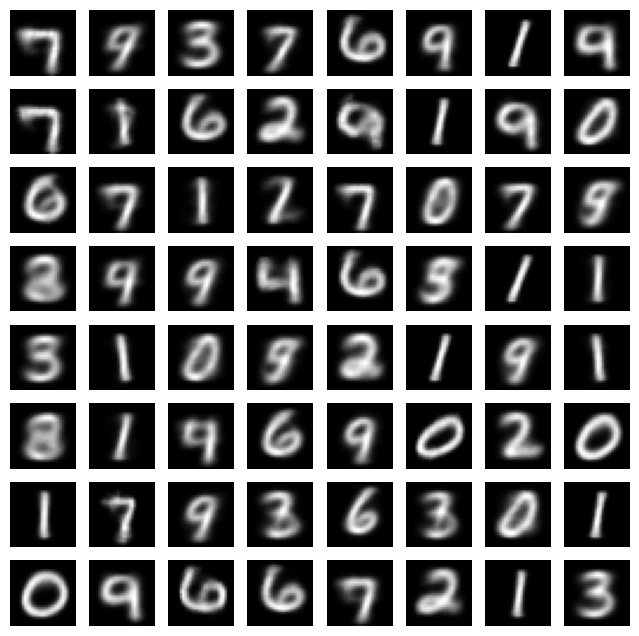

In [57]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [58]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
pred_circ_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_circ_all.append(np.argmax(labels[:, (fuzzy_labels-2):].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [59]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)
pred_circ_all = np.concatenate(pred_circ_all, axis=0)

In [60]:
np.sum(y_all==pred_y_all)/len(y_all)

0.9454

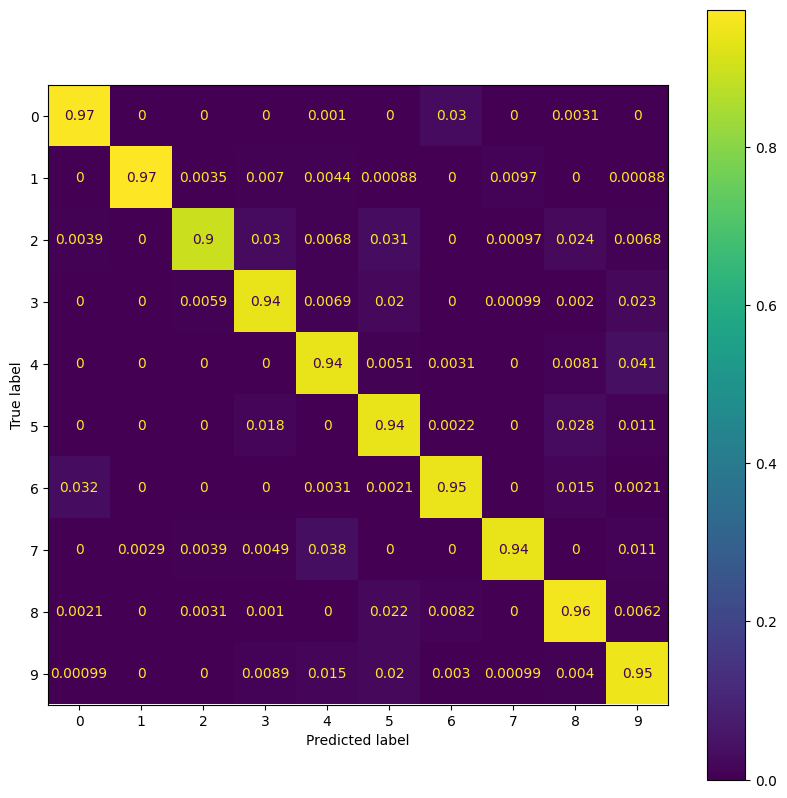

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(10,10))
cmd.plot(ax=ax)

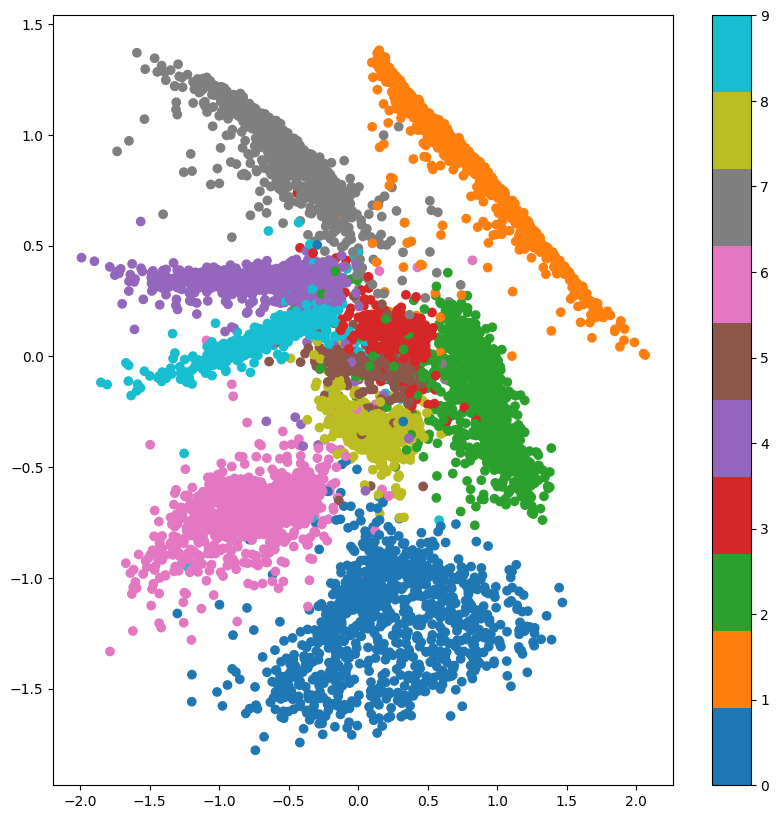

In [62]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_origin_labels.webp')

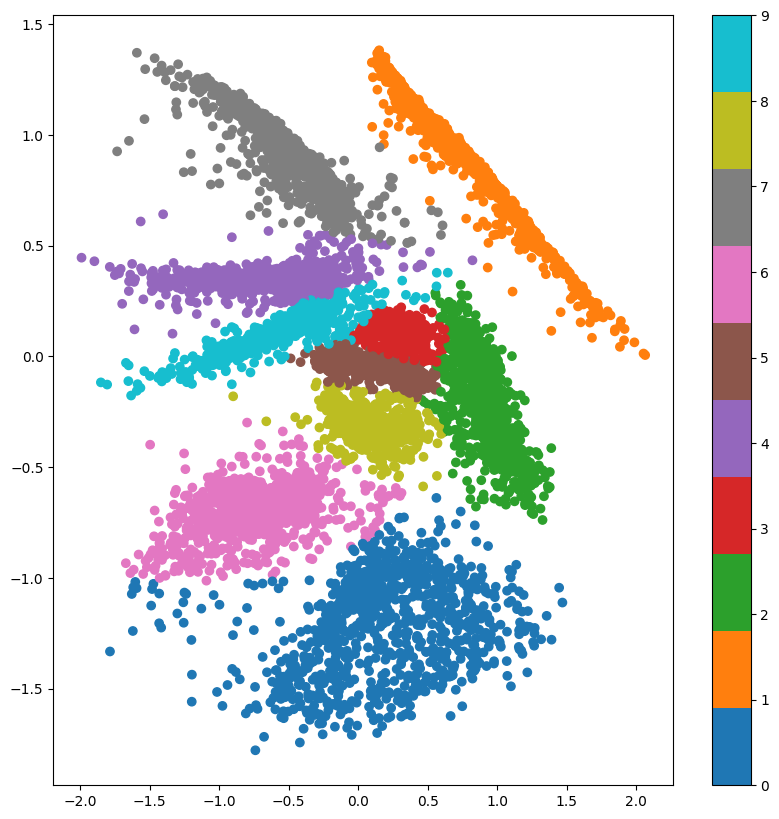

In [63]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

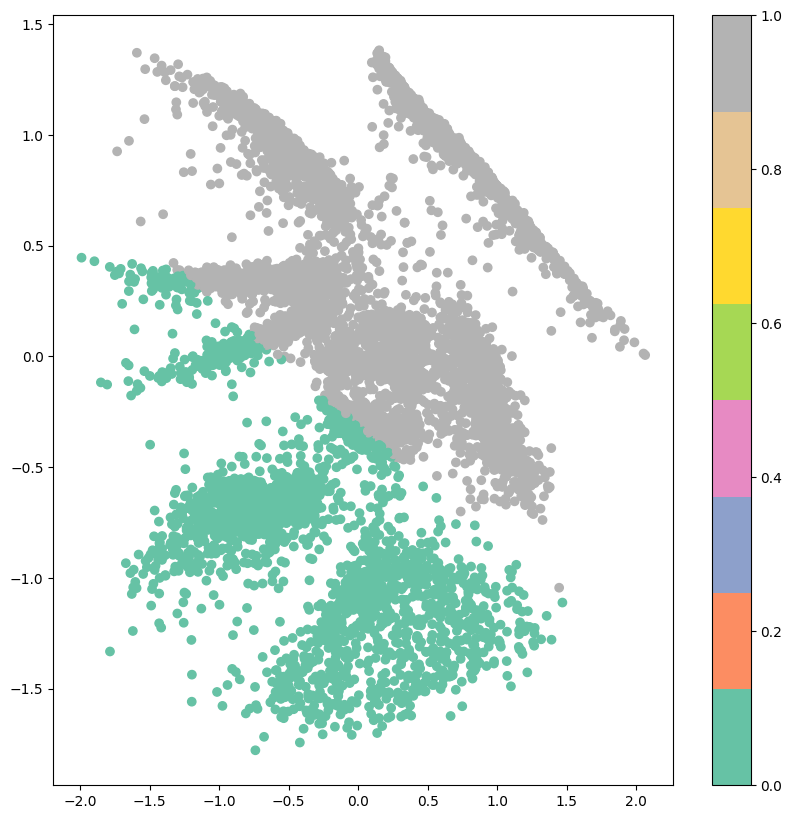

In [64]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='Set2')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_circles.webp')

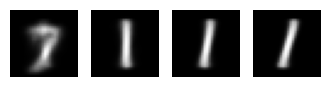

In [65]:
n = 4
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 1.2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('cvae_mnist_interp.webp')